In [1]:
import pandas as pd
import tushare as ts
import numpy as np
import matplotlib.pyplot as plt
import os
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
"""
Step 1
Prepare minutes price data
"""
# # 1.1 Read data
# input_path = 'data/三家银行A H分钟收盘价.xlsx'
# # converter = dict(zip(['600036.SH', '招商银行','工商银行','农业银行','3968.HK','招商银行.1','工商银行.1','农业银行.1'], [str,float,float,float,str,float,float,float]))
# df_input = pd.read_excel(input_path,converters={'600036.SH':str, '3968.HK':str})

# # 1.2 Segment time str
# df_AH= pd.merge(df_input[['600036.SH', '招商银行','工商银行','农业银行']].drop([0,1]).dropna(), \
#     df_input[['3968.HK','招商银行.1','工商银行.1','农业银行.1']].drop([0,1]).dropna(), \
#         how='inner',left_on='600036.SH', right_on='3968.HK').drop('3968.HK',axis=1).rename(columns= {'600036.SH':'date'})
# df_date = df_AH['date'].str.split(' ',expand=True).rename(columns={0:'date', 1:'time'})
# df_AH['date'] = df_date['date'].str.replace('-','')
# df_AH['time'] = df_date['time']
# df_AH[['招商银行','工商银行','农业银行','招商银行.1','工商银行.1','农业银行.1']] = df_AH[['招商银行','工商银行','农业银行','招商银行.1','工商银行.1','农业银行.1']].astype(float)

# # 1.3 Exchage rate collected
# pro = ts.pro_api('00d803b166f55fc30c178d74c158985136010d6bd19271b182059eef')
# start_date = '2021-01-04'
# end_date = '2022-02-25'
# df_CNY = pro.fx_daily(ts_code='USDCNH.FXCM', start_date=start_date, end_date=end_date).iloc[::-1].reset_index(drop=True)
# df_HKD = pro.fx_daily(ts_code='USDHKD.FXCM', start_date=start_date, end_date=end_date).iloc[::-1].reset_index(drop=True)
# ER_feature_list = ['trade_date', 'ask_close']
# # Exchage Rate
# df_ER = df_CNY[ER_feature_list].rename(columns={'ask_close':'CNY2USD'}).merge(df_HKD[ER_feature_list].rename(columns={'ask_close':'HKD2USD'}))
# df_AH = pd.merge(df_AH, df_ER, left_on='date', right_on='trade_date', how='left').dropna().drop('trade_date',axis=1)

# # 1.4 Uniform measuring unit to USD
# df_AH['招商银行'] = df_AH['招商银行'] / df_AH['CNY2USD']
# df_AH['招商银行.1'] = df_AH['招商银行.1'] / df_AH['HKD2USD']
# df_AH['工商银行'] = df_AH['工商银行'] / df_AH['CNY2USD']
# df_AH['工商银行.1'] = df_AH['工商银行.1'] / df_AH['HKD2USD']
# df_AH['农业银行'] = df_AH['农业银行'] / df_AH['CNY2USD']
# df_AH['农业银行.1'] = df_AH['农业银行.1'] / df_AH['HKD2USD']

# df_AH.to_excel('data/df_AH.xlsx')

df_AH = pd.read_excel('data/df_AH.xlsx')


/Users/kuzaowuwei/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kuzaowuwei/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kuzaowuwei/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

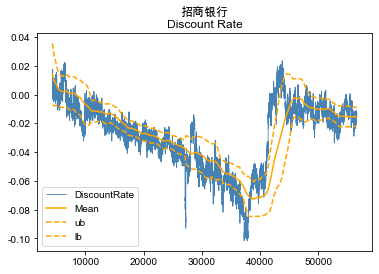

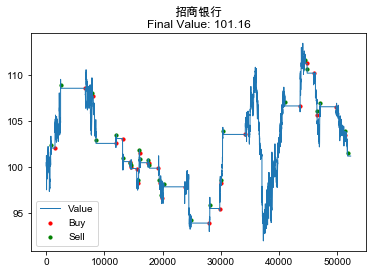

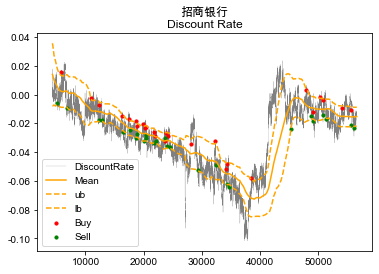

In [25]:

"""港股通的交易费用包含佣金、股票印花税、交易徵费、交易费、中央结算收费。
1、佣金：每宗交易金额的0.25%，支付予证券公司  
2、股票印花税：每宗交易金额的0.1%，支付予香港政府  
3、交易徵费：每宗交易金额的0.003%，支付予证监会  
4、交易费：每宗交易金额的0.005%，支付予交易所  
5、中央结算收费：每宗交易金额的0.002%，支付予结算所(最低港币2元,最高港币100元)"""


class stock:
    def __init__(self, name, df_AH):
        self.transaction_rate = np.sum([0.0025, 0.001, 0.00003, 0.00005, 0.00002])
        self.name = name
        self.df_AH = df_AH
        self.n = len(self.df_AH)
        self.df_AH.columns = ['A','H']
        self.rolling_window_size = 60 * 24 * 3
        self.df_AH['DR'] =1 - (self.df_AH['H'])/self.df_AH['A']
        self.adjust_boundry()
        self.df_AH['DR_mean'] = self.df_AH['DR'].rolling(self.rolling_window_size).mean()
        self.df_AH['DR_std'] = self.df_AH['DR_adjust'].rolling(self.rolling_window_size).std()
        self.df_AH['DR_ub'] = self.df_AH['DR_mean']+self.df_AH['DR_std'] * 1
        self.df_AH['DR_lb'] = self.df_AH['DR_mean']-self.df_AH['DR_std'] 
        
    
    def adjust_boundry(self):
        H = self.df_AH['H'].values
        for t in range(self.n):
            if H[t] > self.df_AH['A'][t]:
                H[t] *= 1 + self.transaction_rate
            elif H[t] < self.df_AH['A'][t]:
                H[t] *= 1 - self.transaction_rate
        self.df_AH['H_adjust'] = H
        self.df_AH['DR_adjust'] = 1 - self.df_AH['H_adjust']/self.df_AH['A']


    def draw_price(self, save_path=''):
        plt.plot(self.df_AH.dropna()['A'],linewidth=1,label='A')
        plt.plot(self.df_AH.dropna()['H'],linewidth=1,label='HK')
        plt.legend()
        plt.title(self.name)
        if save_path != '':
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            plt.savefig(save_path+ '/' + self.name + 'price.png',dpi=600, bbox_inches='tight')
        plt.show()
    
    def draw_DR(self, save_path=''):
        plt.plot(self.df_AH.dropna()['DR'], color='steelblue', label='DiscountRate',linewidth=0.8)
        plt.plot(self.df_AH.dropna()['DR_mean'], color='orange', label='Mean')
        plt.plot(self.df_AH.dropna()['DR_ub'], color='orange',linestyle='--', label='ub')
        plt.plot(self.df_AH.dropna()['DR_lb'], color='orange',linestyle='--', label='lb')
        plt.legend()
        plt.title(self.name + '\nDiscount Rate')
        if save_path != '':
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            plt.savefig(save_path + '/' + self.name + 'DR.png',dpi=600, bbox_inches='tight')
        plt.show()

    def trading_rule(self, psntValue=100,show_transaction=False,save_path=''):
        # extract data
        df = self.df_AH
        df = df.dropna(how='any')
        close = df['H'].values
        open = df['H'].values
        ub = df['DR_ub'].values
        lb = df['DR_lb'].values
        DR = df['DR'].values
        n = len(df)
        # initialize state
        value = np.zeros(n)
        buyPoint = np.zeros(n)
        sellPoint = np.zeros(n)
        psntVolm = psntValue/open[0]
        isAllIn = True
        isSell = False
        isBuy = False
        for t in range(n):
            # cal present value
            if isAllIn:
                psntValue = psntVolm * open[t]
            value[t] = psntValue
            # no operation
            if not (isBuy or isSell):
                if DR[t] < lb[t] and isAllIn:
                    isSell = True
                    # all in
                elif DR[t] > ub[t] and not isAllIn:
                    # all out
                    isBuy = True
            # operation
            elif isBuy:
                buyPoint[t] = 1
                isBuy = False
                psntVolm = psntValue/(open[t] * (1 + self.transaction_rate))
                isAllIn = True
            else:# sell
                sellPoint[t] = 1
                psntValue *= (1 - self.transaction_rate)
                isSell = False
                isAllIn = False
        # value, psntValue, buyPoint, sellPoint = trading_rule(df_AH)

        plt.plot(value, label='Value',linewidth=1)
        if show_transaction:
            plt.scatter(np.arange(len(value))[buyPoint == 1],value[buyPoint == 1],color='red',label='Buy',s=10)
            plt.scatter(np.arange(len(value))[sellPoint == 1],value[sellPoint == 1],color='green',label='Sell',s=10)
        plt.legend()
        plt.title(self.name + '\nFinal Value: {:.2f}'.format(psntValue))
        if save_path != '':
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            plt.savefig(save_path+ '/' + self.name + 'value.png',dpi=600, bbox_inches='tight')
        plt.show()

        if show_transaction:
            plt.plot(df['DR'], color='gray', label='DiscountRate',linewidth=0.2,zorder=1)
            plt.plot(df['DR_mean'], color='orange', label='Mean')
            plt.plot(df['DR_ub'], color='orange',linestyle='--', label='ub')
            plt.plot(df['DR_lb'], color='orange',linestyle='--', label='lb')
            plt.scatter(df.index[buyPoint == 1],df['DR'][buyPoint == 1],color='red',label='Buy',s=10,zorder=2)
            plt.scatter(df.index[sellPoint == 1],df['DR'][sellPoint == 1],color='green',label='Sell',s=10,zorder=2)
            plt.legend()
            plt.title(self.name + '\nDiscount Rate')
            # if save_path != '':
            #     if not os.path.exists(save_path):
            #         os.makedirs(save_path)
            #     plt.savefig(save_path + '/' + self.name + 'DR_transaction.png',dpi=600, bbox_inches='tight')
            plt.show()
        # return value, psntValue, buyPoint, sellPoint

stock1 = stock('招商银行',df_AH=df_AH[['招商银行','招商银行.1']])
stock2 = stock('工商银行',df_AH=df_AH[['工商银行','工商银行.1']])
stock3 = stock('农业银行',df_AH=df_AH[['农业银行','农业银行.1']])

# stock1.draw_price()
stock1.draw_DR()
stock1.trading_rule(show_transaction=True)
# stock2.draw_price(save_path='data')
# stock2.draw_DR(save_path='data')
# stock2.trading_rule(save_path='data')
# stock3.draw_price(save_path='data')
# stock3.draw_DR(save_path='data')
# stock3.trading_rule(save_path='data')

In [13]:
t = pd.DataFrame(['a',1,2,3])

In [18]:
t.index[1]

1

In [ ]:
t